### Imports

In [57]:
# --- 0) Imports you already have in your project structure ---
from challenge.data.ingest import load_data
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from challenge.data.preprocess import remove_na, imputation, preprocess_test_data
from challenge.data.feature_selection import split_histogram_features, select_top_features
from challenge.data.balancing import scale_and_balance
from challenge.analysis.pca_analysis import pca_inspect
from challenge.visualization.feature_correlation import plot_correlation_heatmap
from challenge.modelling.train_eval import cv_cost, evaluate_on_test
from challenge.visualization.performance_viz import plot_confusion, plot_cost_threshold_curve
from challenge.modelling.threshold_tuning import tune_threshold
from challenge.visualization.eda_plots import eda_plots_with_stats

# Extra ML models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import numpy,pandas,imblearn

try:
    from lightgbm import LGBMClassifier
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

### Load Data & Clean

In [58]:
train, test = load_data('./dataset/aps_failure_training_set.csv', './dataset/aps_failure_test_set.csv')

Train shape: (60000, 171), Test shape: (16000, 171)


In [59]:
# Missingness %
nan_count = {col: 100 * train[col].isna().sum() / len(train) for col in train.columns if col != "class"}
high_missing = [k for k, v in nan_count.items() if v > 70]
constant = [col for col in train.columns if train[col].nunique() <= 1]
features_to_remove = sorted(set(high_missing + constant))

In [60]:
# Clean train (drop >70% NA cols and rows with NA in <5% NA cols)
clean_train, features_to_remove = remove_na(train, nan_count)  # returns cleaned df and final removed list

# Split label/feature AFTER cleaning
y_train_raw = clean_train["class"].replace({"neg": 0, "pos": 1})
x_train_raw = clean_train.drop(columns=["class"])

Removed constant columns: ['cd_000'] 
Current Shape: (60000, 170) 
Removed columns with >%70 Missing Values: ['ab_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'cr_000']
Current Shape: (60000, 163) 
Removed missing rows of Columns <%4 Missing Values: ['aa_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'as_000', 'at_000', 'au_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'by_000', 'cb_000', 'ci_000', 'cj_000', 'ck_000', 'cn_000', 'cn_001', 'cn_002', 'cn_003', 'cn_004', 'cn_005', 'cn_006', 

/var/folders/kk/clxttl7j5wvbs_fcnydk843r0000gn/T/ipykernel_14910/3464760471.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train_raw = clean_train["class"].replace({"neg": 0, "pos": 1})


In [61]:
import pandas as pd
import numpy as np  
from scipy.stats import ks_2samp

def select_features_ks(X: pd.DataFrame, y: pd.Series, p_value_threshold: float = 0.05) -> list[str]:
    """
    Selects features using the 2-sample Kolmogorov-Smirnov (K-S) test.
    
    This test compares the empirical cumulative distribution functions (ECDFs)
    of each feature between the negative (0) and positive (1) classes.
    Features where the distributions are statistically different (p-value < threshold)
    are selected.
    """
    X_neg = X[y == 0]
    X_pos = X[y == 1]
    
    selected_features = []
    
    print(f"Starting K-S test on {X.shape[1]} features...")
    
    for col in X.columns:
        try:
            # 1. Explicitly replace inf with NaN
            data_neg = X_neg[col].replace([np.inf, -np.inf], np.nan)
            data_pos = X_pos[col].replace([np.inf, -np.inf], np.nan)
            
            # 2. Drop NaN values
            data_neg = data_neg.dropna()
            data_pos = data_pos.dropna()

            # Perform the K-S test if both samples have data
            if not data_neg.empty and not data_pos.empty:
                stat, p_value = ks_2samp(data_neg, data_pos)
                
                # If the p-value is below the threshold, the distributions are different
                if p_value <= p_value_threshold:
                    selected_features.append(col)
            else:
                # One of the classes had no valid data for this column
                pass 
                
        except ValueError:
            # This can happen for other reasons, e.g., all constant values
            print(f"Skipping feature {col} due to insufficient data for K-S test.")
            
    print(f"K-S test complete. Selected {len(selected_features)} out of {X.shape[1]} features.")
    return selected_features

def get_feature_pvalues(X: pd.DataFrame, y: pd.Series) -> pd.Series:
    """
    Performs the 2-sample K-S test on all features and returns their p-values.
    """
    X_neg = X[y == 0]
    X_pos = X[y == 1]
    
    p_values = {}
    
    for col in X.columns:
        try:
            data_neg = X_neg[col].replace([np.inf, -np.inf], np.nan).dropna()
            data_pos = X_pos[col].replace([np.inf, -np.inf], np.nan).dropna()

            if not data_neg.empty and not data_pos.empty:
                stat, p_value = ks_2samp(data_neg, data_pos)
                p_values[col] = p_value
            else:
                p_values[col] = 1.0  # Assign max p-value if test can't be run
                
        except ValueError:
            p_values[col] = 1.0  # Assign max p-value on error
            
    return pd.Series(p_values, name="p_value")

In [62]:
feature_pvals = get_feature_pvalues(x_train_raw, y_train_raw)
print(feature_pvals.sort_values().to_string())

aa_000     0.000000e+00
bi_000     0.000000e+00
bh_000     0.000000e+00
bg_000     0.000000e+00
bb_000     0.000000e+00
ba_006     0.000000e+00
ba_005     0.000000e+00
ba_004     0.000000e+00
ba_003     0.000000e+00
ba_002     0.000000e+00
ba_001     0.000000e+00
ba_000     0.000000e+00
az_005     0.000000e+00
az_002     0.000000e+00
az_001     0.000000e+00
az_000     0.000000e+00
bj_000     0.000000e+00
bt_000     0.000000e+00
bu_000     0.000000e+00
bv_000     0.000000e+00
dd_000     0.000000e+00
cs_005     0.000000e+00
cs_004     0.000000e+00
cs_003     0.000000e+00
cs_002     0.000000e+00
cs_001     0.000000e+00
cs_000     0.000000e+00
ay_008     0.000000e+00
cq_000     0.000000e+00
cn_003     0.000000e+00
cn_002     0.000000e+00
ck_000     0.000000e+00
ci_000     0.000000e+00
cc_000     0.000000e+00
by_000     0.000000e+00
bx_000     0.000000e+00
cn_004     0.000000e+00
ay_007     0.000000e+00
dn_000     0.000000e+00
ee_004     0.000000e+00
ai_000     0.000000e+00
ah_000     0.000

In [63]:
significant_features = select_features_ks(x_train_raw, y_train_raw, p_value_threshold=0.01)

print("Significant features:", significant_features)

Starting K-S test on 162 features...
K-S test complete. Selected 146 out of 162 features.
Significant features: ['aa_000', 'ac_000', 'ad_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'at_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000', 'bl_000', 'bm_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000', 'cb_000', 'cc_000', 'ce_000', 'cf_000', 'cg_000', 'ci_000', 'cj_000', 'ck_000', 'cl_000', 'cm_000', 'cn_000', 'cn_001', 'cn_002',

In [64]:
x_train_filtered = x_train_raw[significant_features]
x_train_filtered.shape[1]

146

In [56]:
%%capture
pip install sdv

In [6]:
# Impute (median + MICE) using TRAIN ONLY; returns imputed X, fitted imputers, and list of median-imputed columns
X_train_imp, med_imp, mice_imp, median_feats = imputation(X_train_raw, nan_count)

[IterativeImputer] Completing matrix with shape (58190, 162)
[IterativeImputer] Change: 98062837.48761189, scaled tolerance: 8584297.742 
[IterativeImputer] Change: 103013100.02397275, scaled tolerance: 8584297.742 
[IterativeImputer] Change: 105434574.58716878, scaled tolerance: 8584297.742 
[IterativeImputer] Change: 116371151.63715042, scaled tolerance: 8584297.742 
[IterativeImputer] Change: 125958541.57416713, scaled tolerance: 8584297.742 
[IterativeImputer] Change: 170178008.225633, scaled tolerance: 8584297.742 
[IterativeImputer] Change: 52975964.28498013, scaled tolerance: 8584297.742 
[IterativeImputer] Change: 156984980.54948366, scaled tolerance: 8584297.742 
[IterativeImputer] Change: 110092647.90985657, scaled tolerance: 8584297.742 
[IterativeImputer] Change: 153638362.089749, scaled tolerance: 8584297.742 
Median-imputed features: 42 | MICE features: 21


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [7]:
# Preprocess test with the SAME schema & imputers
X_test_imp, y_test = preprocess_test_data(
    test,
    removed_features=features_to_remove,
    median_feats=median_feats,
    median_imputer=med_imp,
    mice_imputer=mice_imp
)   
# Ensure aligned column order 
X_test_imp = X_test_imp[X_train_imp.columns]

[IterativeImputer] Completing matrix with shape (16000, 162)
X_test Shape: (16000, 162)


In [8]:
# Feature groups & selection (RFE RF → top-15 from each group) ---
X_hist, X_num, hist_cols, num_cols = split_histogram_features(X_train_imp)

In [9]:
X_top_hist = select_top_features(X_hist, y_train)    

Selected top 15 features: ['ag_001', 'ag_002', 'ag_003', 'ay_005', 'ay_006', 'ay_008', 'ba_000', 'ba_003', 'ba_004', 'cn_004', 'cs_002', 'cs_004', 'ee_000', 'ee_005', 'ee_007']


In [10]:
X_top_num = select_top_features(X_num, y_train)    

Selected top 15 features: ['aa_000', 'al_000', 'am_0', 'ap_000', 'aq_000', 'az_001', 'bb_000', 'bj_000', 'bt_000', 'bu_000', 'by_000', 'ci_000', 'ck_000', 'cq_000', 'dn_000']


### EDA

In [11]:
# Build EDA dataframe *from non-imputed, cleaned data* (x_clean) + numeric class
train_eda_base = x_clean.copy()
train_eda_base["class"] = train_eda_base["class"].replace({"neg": 0, "pos": 1})

# keep only columns that actually exist in this (non-imputed) frame
top_hist_cols = [c for c in X_top_hist.columns if c in train_eda_base.columns]
top_num_cols = [c for c in X_top_num.columns if c in train_eda_base.columns]

/var/folders/kk/clxttl7j5wvbs_fcnydk843r0000gn/T/ipykernel_20099/2371195772.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_eda_base["class"] = train_eda_base["class"].replace({"neg": 0, "pos": 1})


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# Final EDA dataframe 
X_eda_hist = train_eda_base[top_hist_cols + ["class"]].copy()

print(f"Top-15 hist features for EDA ({len(top_hist_cols)} cols): {top_hist_cols}")
print("EDA frame shape:", X_eda_hist.shape)

Top-15 hist features for EDA (15 cols): ['ag_001', 'ag_002', 'ag_003', 'ay_005', 'ay_006', 'ay_008', 'ba_000', 'ba_003', 'ba_004', 'cn_004', 'cs_002', 'cs_004', 'ee_000', 'ee_005', 'ee_007']
EDA frame shape: (58190, 16)


Feature 'ag_001', Class 1 → Mean: 50298.4737, Std: 257155.1893
Feature 'ag_001', Class 0 → Mean: 120.7995, Std: 5271.5730


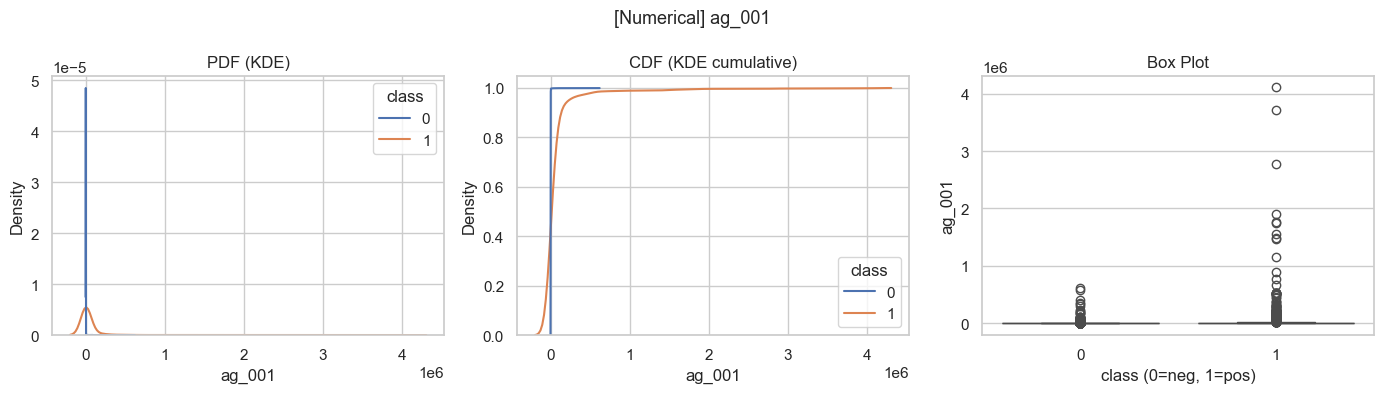

****************************************************************************************************
Feature 'ag_002', Class 1 → Mean: 393895.3976, Std: 991117.3957
Feature 'ag_002', Class 0 → Mean: 1872.0579, Std: 57503.2564


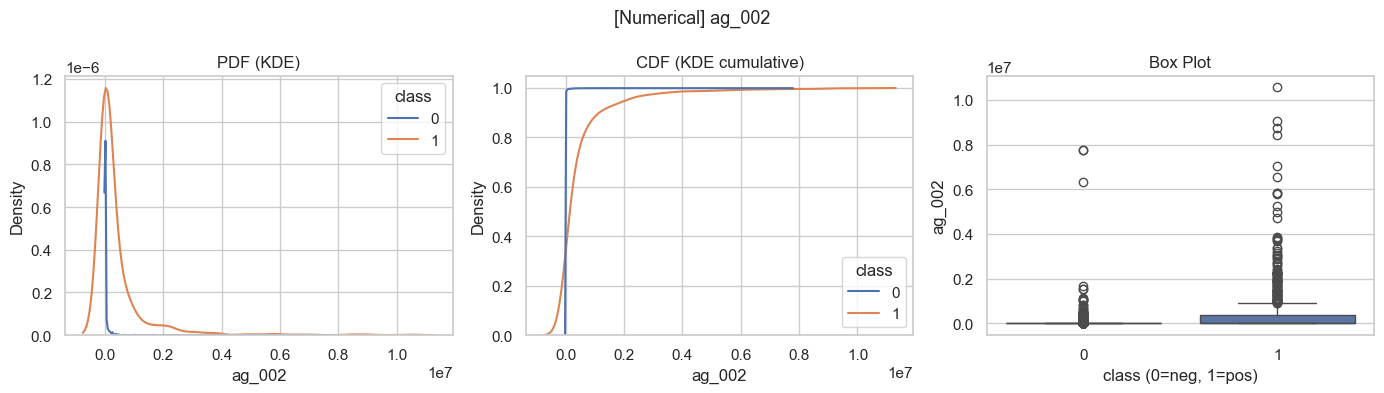

****************************************************************************************************
Feature 'ag_003', Class 1 → Mean: 2581180.4116, Std: 4226366.5590
Feature 'ag_003', Class 0 → Mean: 44161.8919, Std: 412621.0446


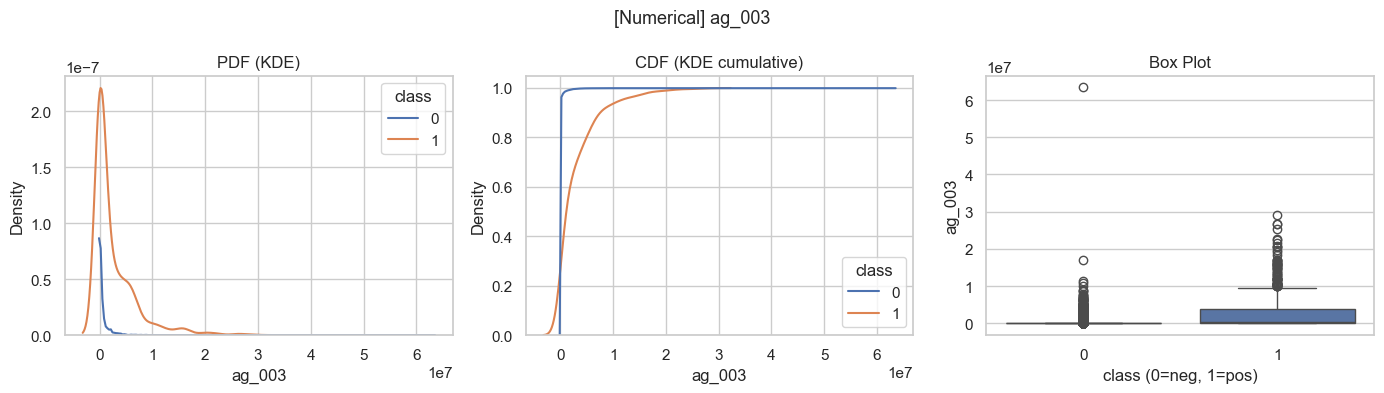

****************************************************************************************************
Feature 'ay_005', Class 1 → Mean: 2439485.4620, Std: 7866317.8186
Feature 'ay_005', Class 0 → Mean: 73687.3237, Std: 936167.5453


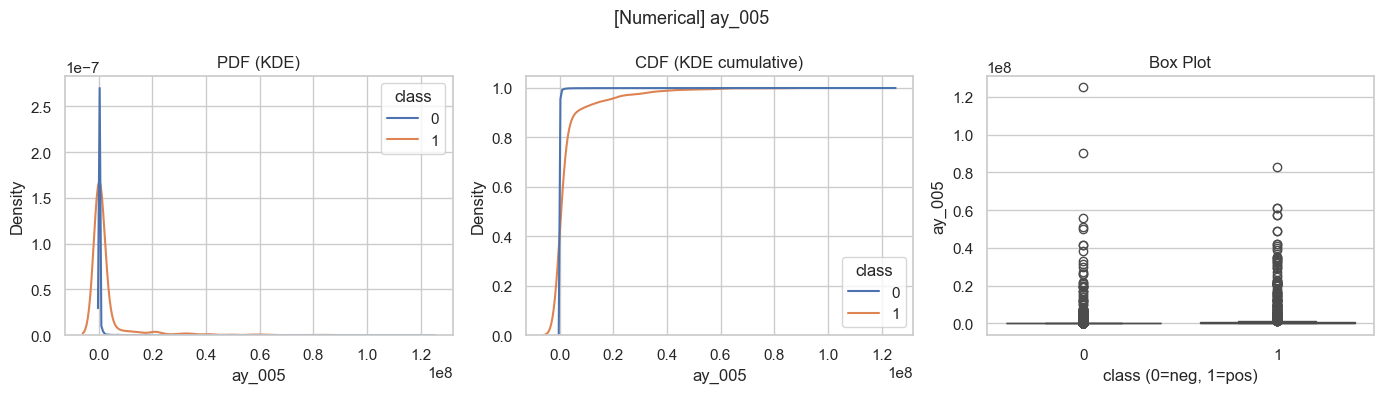

****************************************************************************************************
Feature 'ay_006', Class 1 → Mean: 7050900.5038, Std: 13283550.4180
Feature 'ay_006', Class 0 → Mean: 986538.8789, Std: 2728093.5363


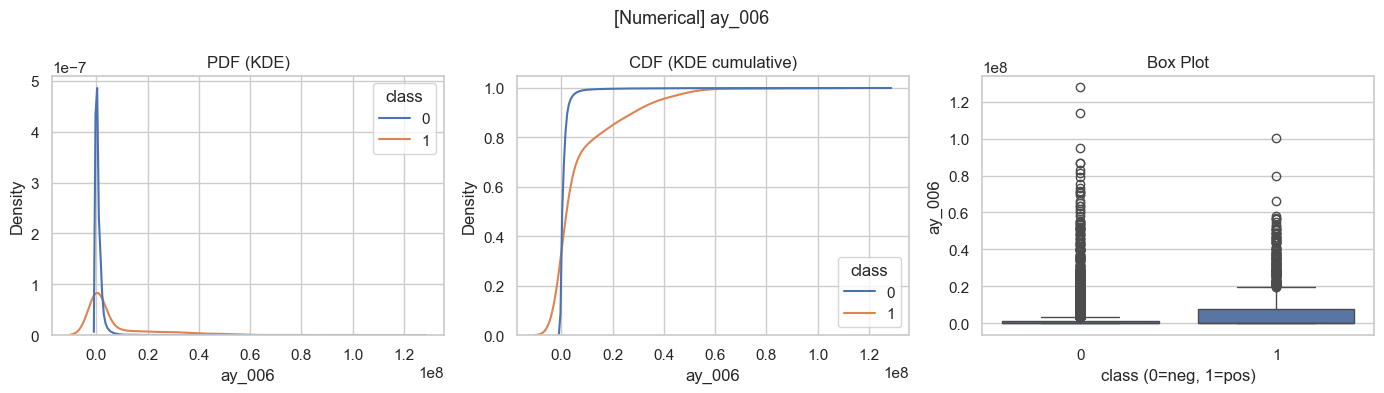

****************************************************************************************************
Feature 'ay_008', Class 1 → Mean: 13398197.0761, Std: 16646447.6369
Feature 'ay_008', Class 0 → Mean: 830152.9171, Std: 2916951.8698


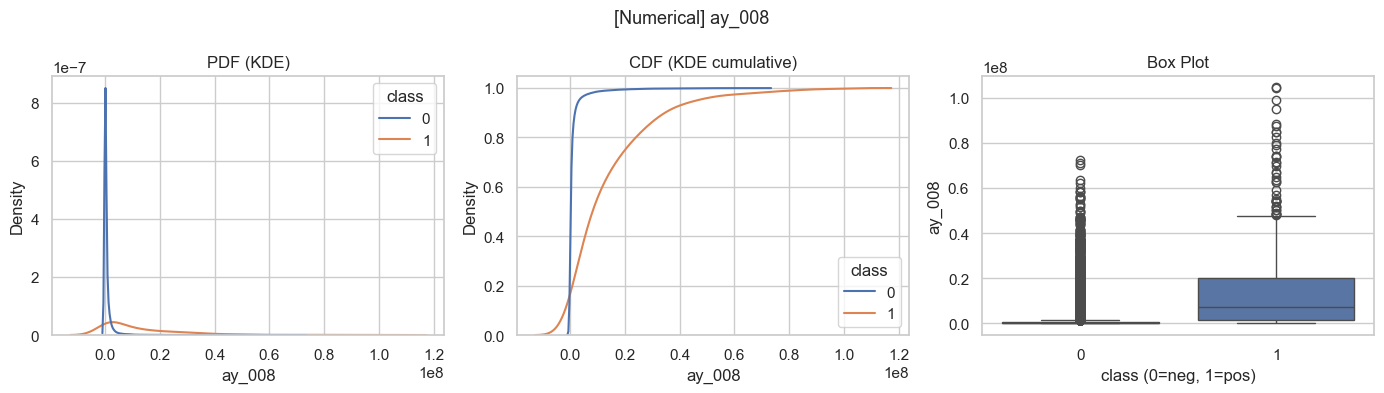

****************************************************************************************************
Feature 'ba_000', Class 1 → Mean: 13859298.4652, Std: 12188450.6032
Feature 'ba_000', Class 0 → Mean: 1186410.7882, Std: 3030446.9432


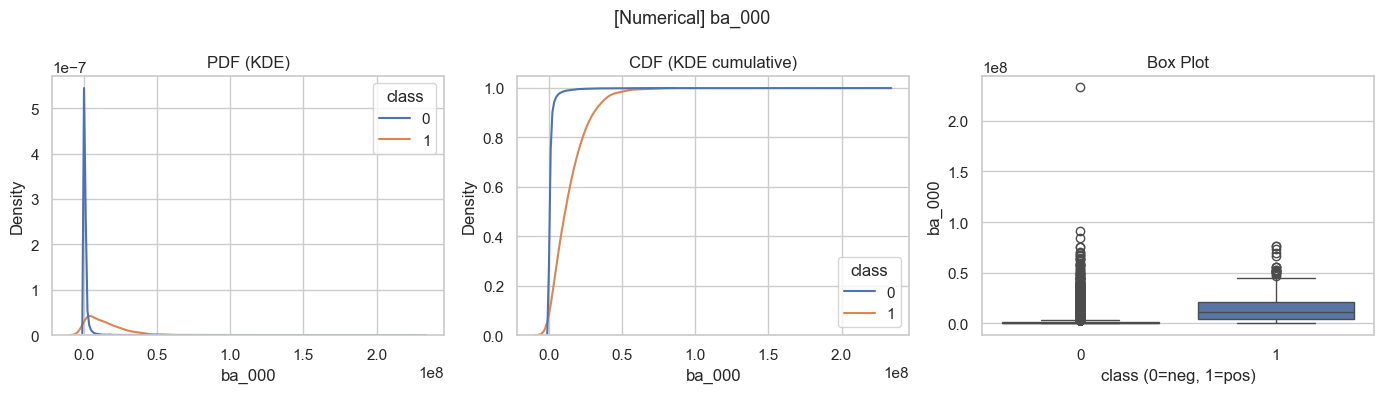

****************************************************************************************************
Feature 'ba_003', Class 1 → Mean: 2917127.8135, Std: 2688873.1590
Feature 'ba_003', Class 0 → Mean: 227995.8879, Std: 567707.0778


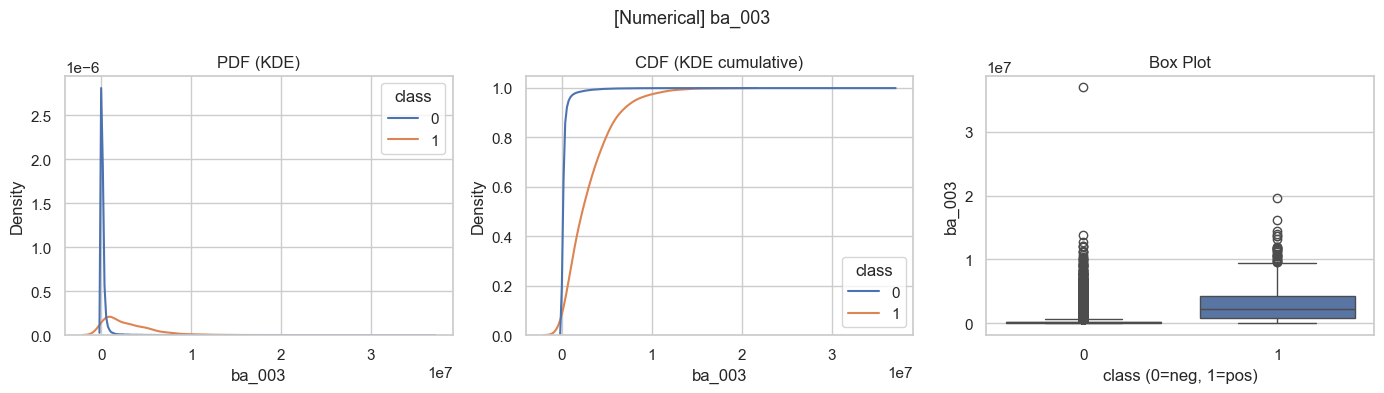

****************************************************************************************************
Feature 'ba_004', Class 1 → Mean: 2189254.6838, Std: 2083520.9086
Feature 'ba_004', Class 0 → Mean: 170981.4623, Std: 391767.7033


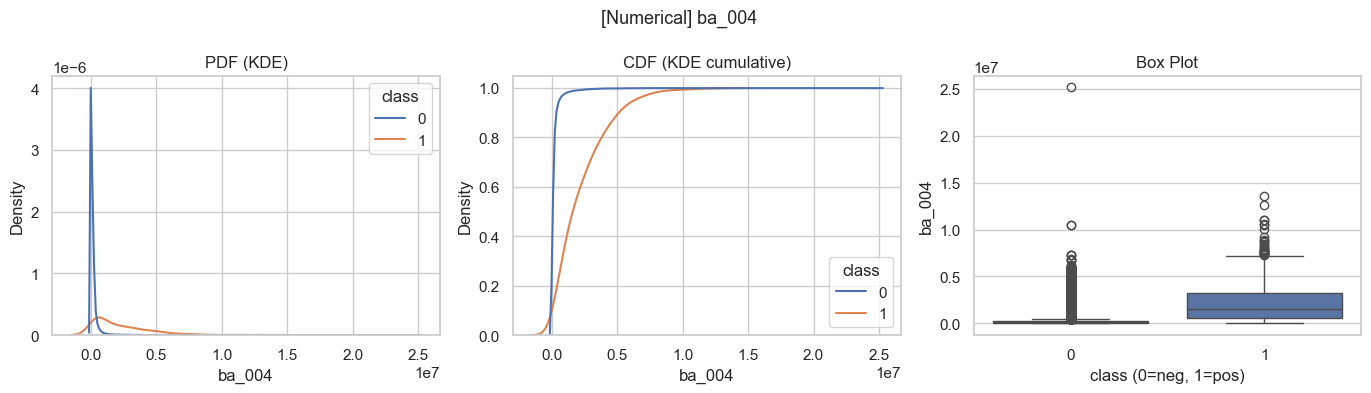

****************************************************************************************************
Feature 'cn_004', Class 1 → Mean: 13514021.6356, Std: 12696948.5868
Feature 'cn_004', Class 0 → Mean: 1073434.5814, Std: 2481345.7404


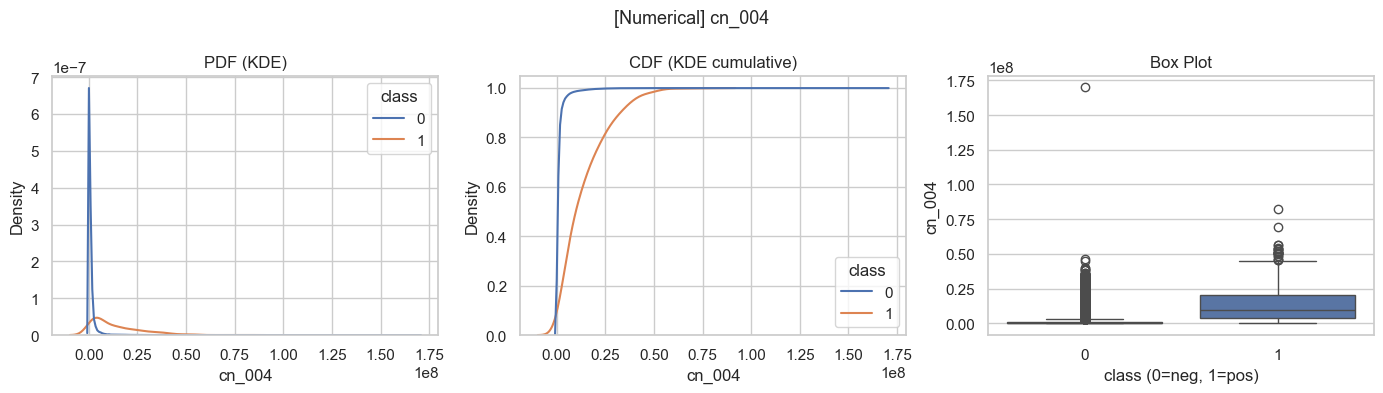

****************************************************************************************************
Feature 'cs_002', Class 1 → Mean: 3661315.7385, Std: 4284979.3915
Feature 'cs_002', Class 0 → Mean: 177688.9800, Std: 971301.9923


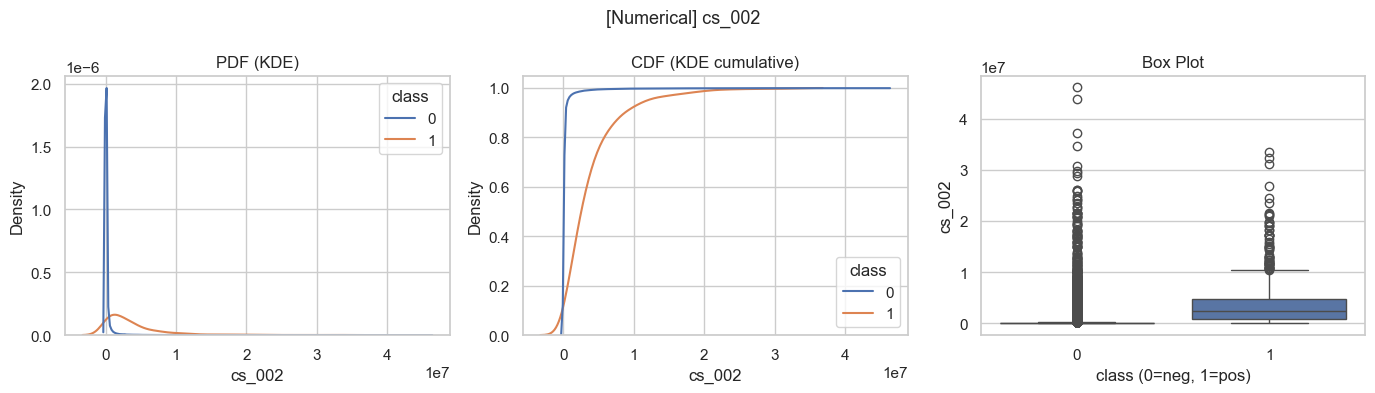

****************************************************************************************************
Feature 'cs_004', Class 1 → Mean: 7301321.0782, Std: 9297144.8734
Feature 'cs_004', Class 0 → Mean: 323490.4087, Std: 1413040.0390


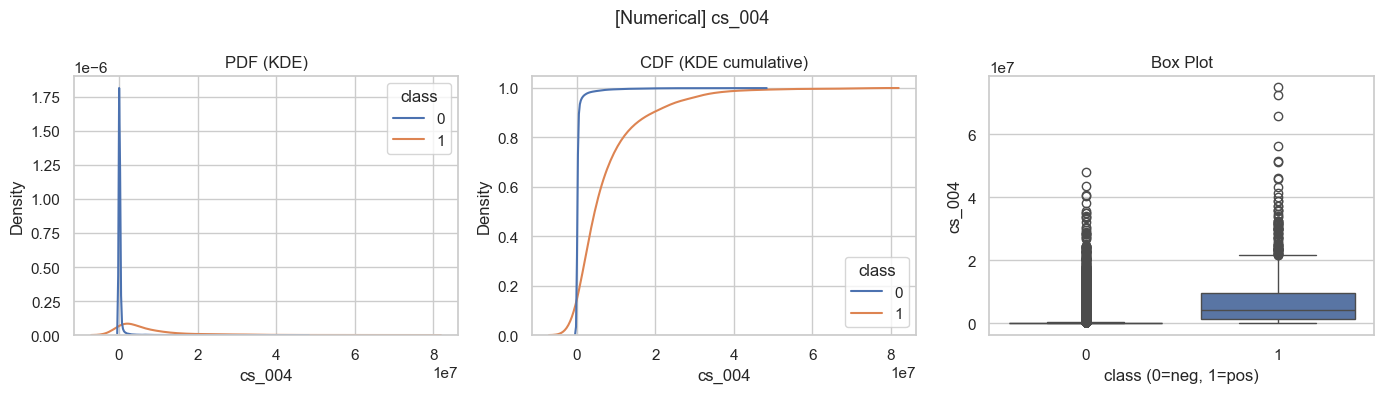

****************************************************************************************************
Feature 'ee_000', Class 1 → Mean: 8284513.6956, Std: 8511051.0433
Feature 'ee_000', Class 0 → Mean: 599112.5499, Std: 1873540.8598


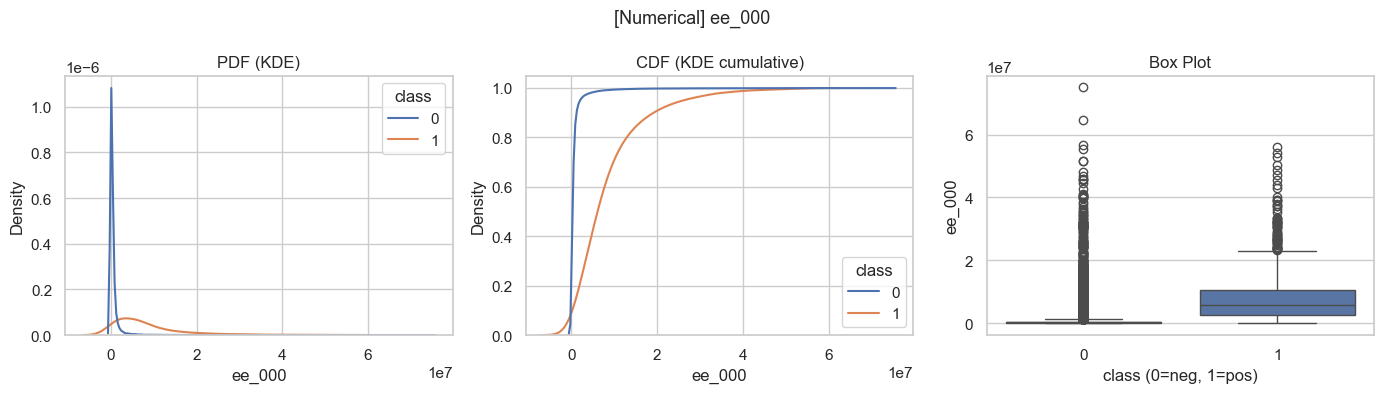

****************************************************************************************************
Feature 'ee_005', Class 1 → Mean: 4634827.8285, Std: 5617661.7205
Feature 'ee_005', Class 0 → Mean: 323860.1219, Std: 669719.6841


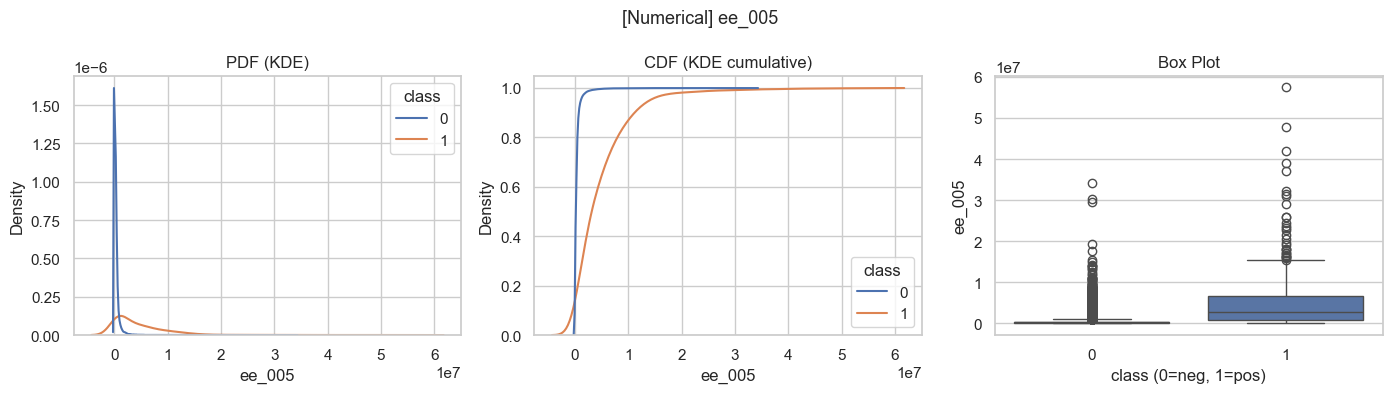

****************************************************************************************************
Feature 'ee_007', Class 1 → Mean: 2445355.0997, Std: 4007011.6519
Feature 'ee_007', Class 0 → Mean: 305854.5063, Std: 1626118.8144


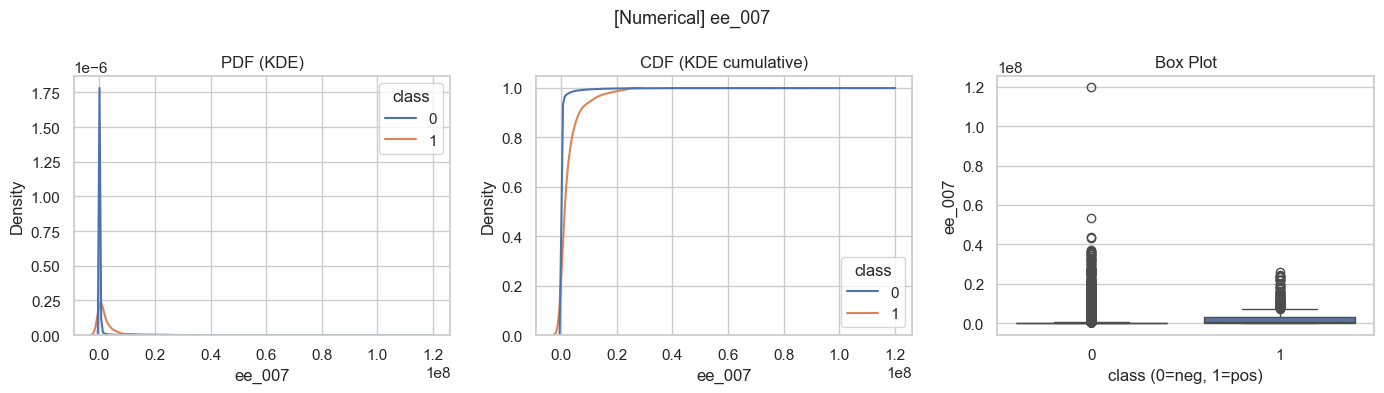

****************************************************************************************************


In [14]:
eda_plots_with_stats(X_eda_hist, title_prefix="[Numerical] ")

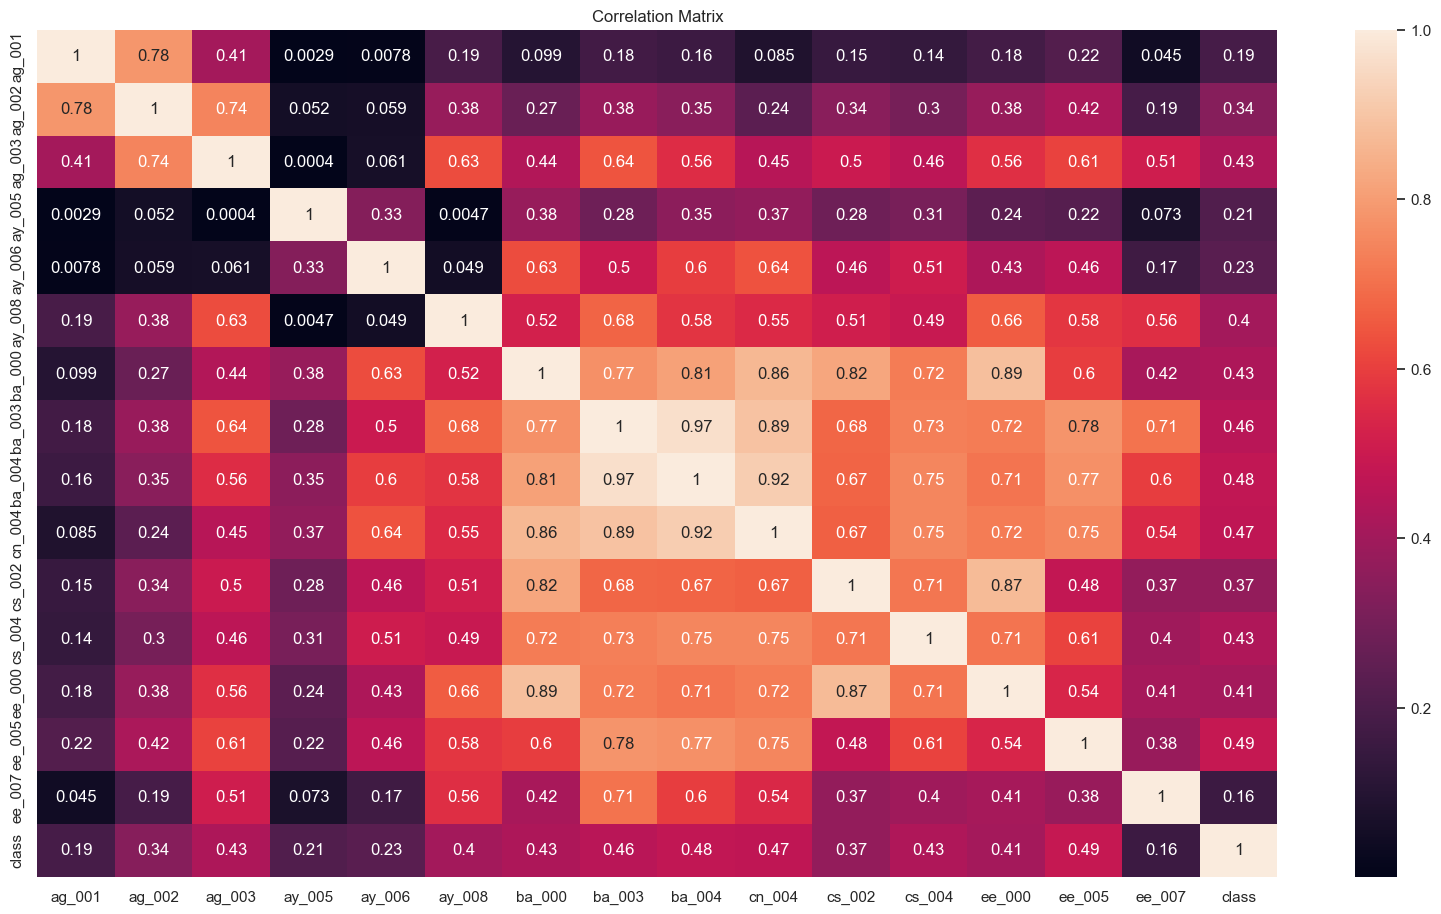

In [14]:
plt.figure(figsize=(20,11))
sns.heatmap(X_eda_hist.corr(),annot=True)
plt.title("Correlation Matrix")
plt.show()

Explained variance ratio: 0.827


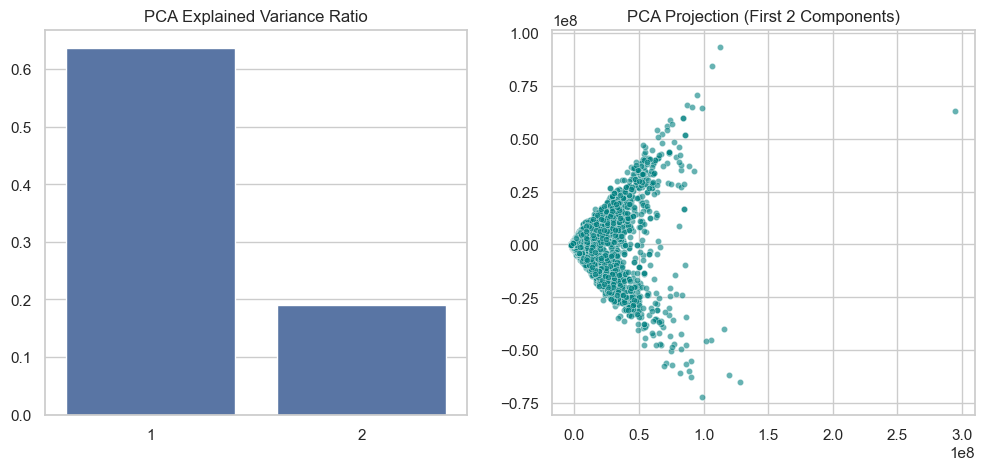

,PC1,PC2
0,1.461198e+06,2.365913e+06
1,-6.779436e+05,5.123548e+05
2,-5.274877e+05,-5.039184e+05
3,-2.596492e+06,-2.197285e+05
4,4.994461e+05,1.167437e+06
...,...,...
58185,4.304111e+06,-1.382919e+06
58186,-2.497793e+06,-1.572603e+05
58187,-2.572398e+06,-2.293395e+05
58188,8.730424e+05,2.891053e+06


In [17]:
pca_inspect(X_eda_hist, n_components=2)     


In [15]:
# Final EDA dataframe 
X_eda_num = train_eda_base[top_num_cols + ["class"]].copy()

print(f"Top-15 num features for EDA ({len(top_num_cols)} cols): {top_num_cols}")
print("EDA frame shape:", X_eda_num.shape)

Top-15 num features for EDA (15 cols): ['aa_000', 'al_000', 'am_0', 'ap_000', 'aq_000', 'az_001', 'bb_000', 'bj_000', 'bt_000', 'bu_000', 'by_000', 'ci_000', 'ck_000', 'cq_000', 'dn_000']
EDA frame shape: (58190, 16)


Feature 'aa_000', Class 1 → Mean: 661266.1458, Std: 436652.7346
Feature 'aa_000', Class 0 → Mean: 49276.3353, Std: 109958.0570


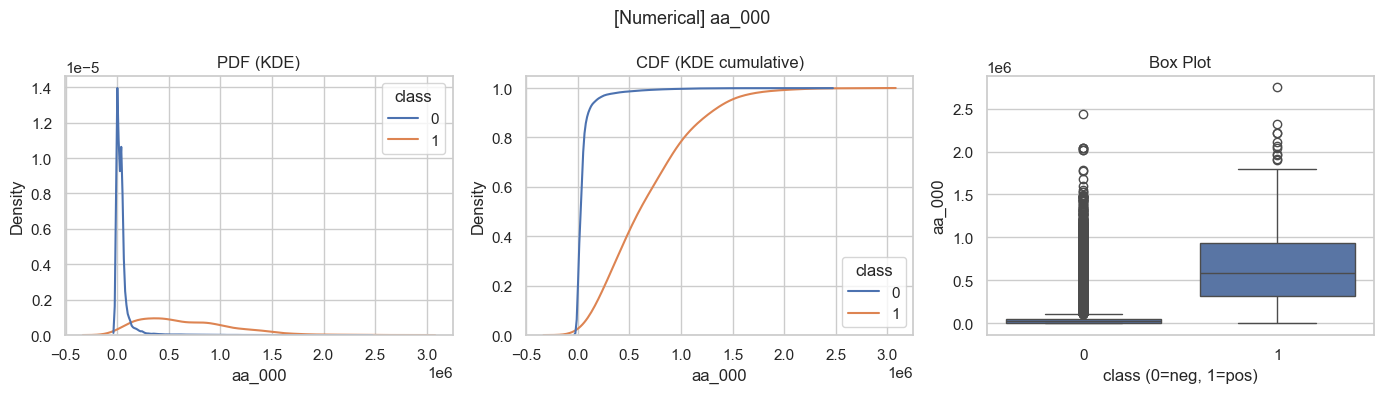

****************************************************************************************************
Feature 'al_000', Class 1 → Mean: 1625476.9325, Std: 2804785.0449
Feature 'al_000', Class 0 → Mean: 32611.1813, Std: 355080.8547


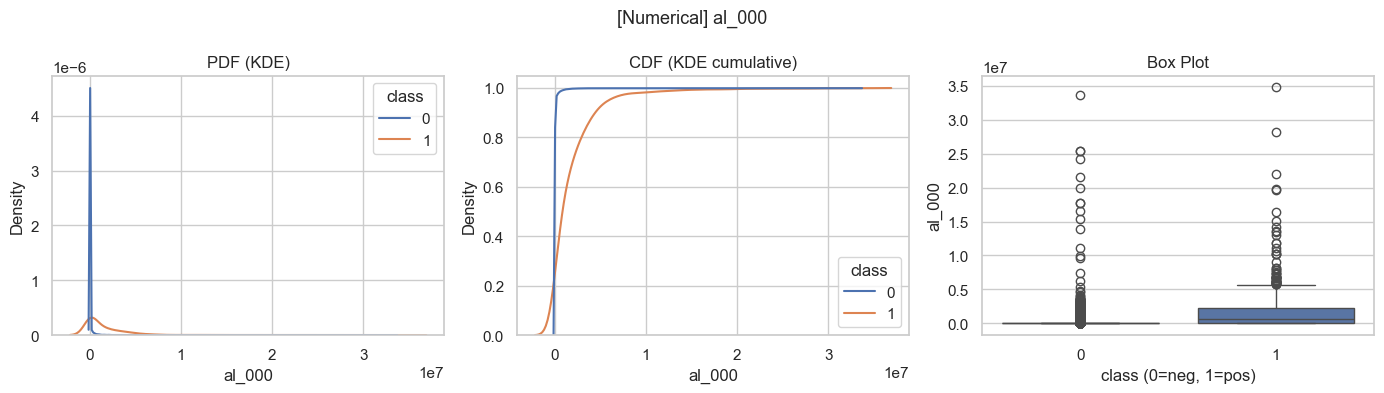

****************************************************************************************************
Feature 'am_0', Class 1 → Mean: 2584266.0300, Std: 4339939.4761
Feature 'am_0', Class 0 → Mean: 50609.9895, Std: 563796.2956


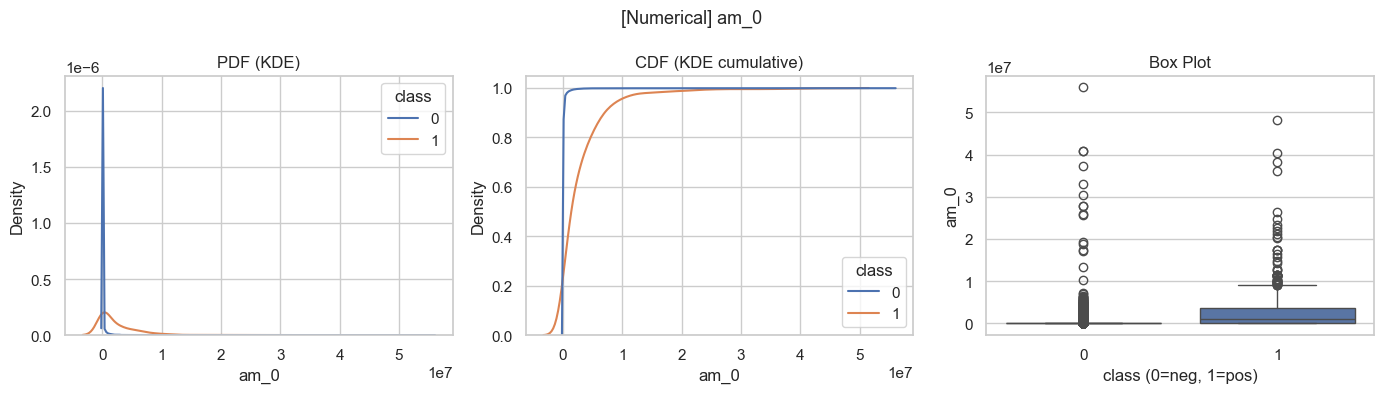

****************************************************************************************************
Feature 'ap_000', Class 1 → Mean: 13366682.0643, Std: 10261130.6648
Feature 'ap_000', Class 0 → Mean: 797709.3718, Std: 2304386.4862


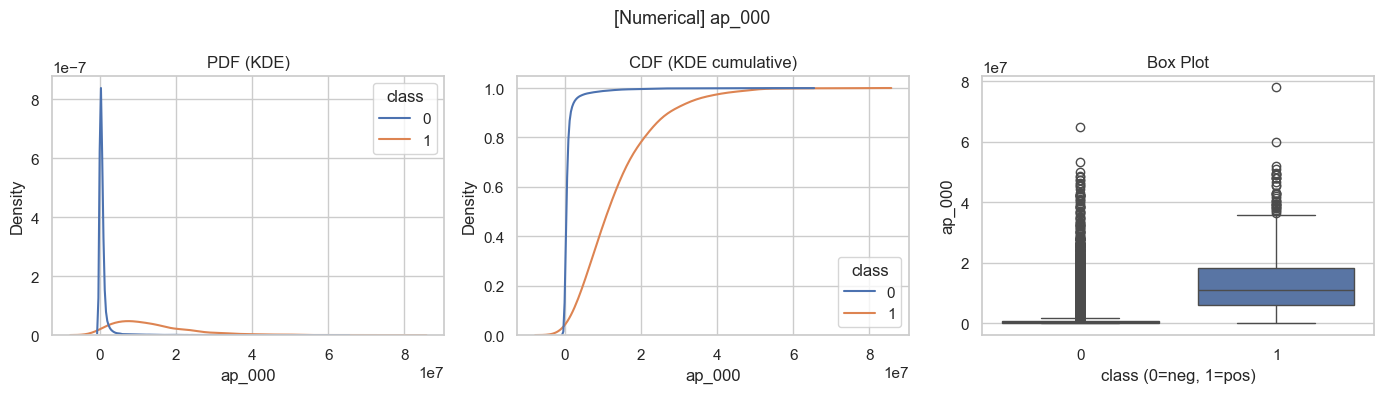

****************************************************************************************************
Feature 'aq_000', Class 1 → Mean: 5615061.2926, Std: 4259605.3091
Feature 'aq_000', Class 0 → Mean: 356755.4061, Std: 923900.9102


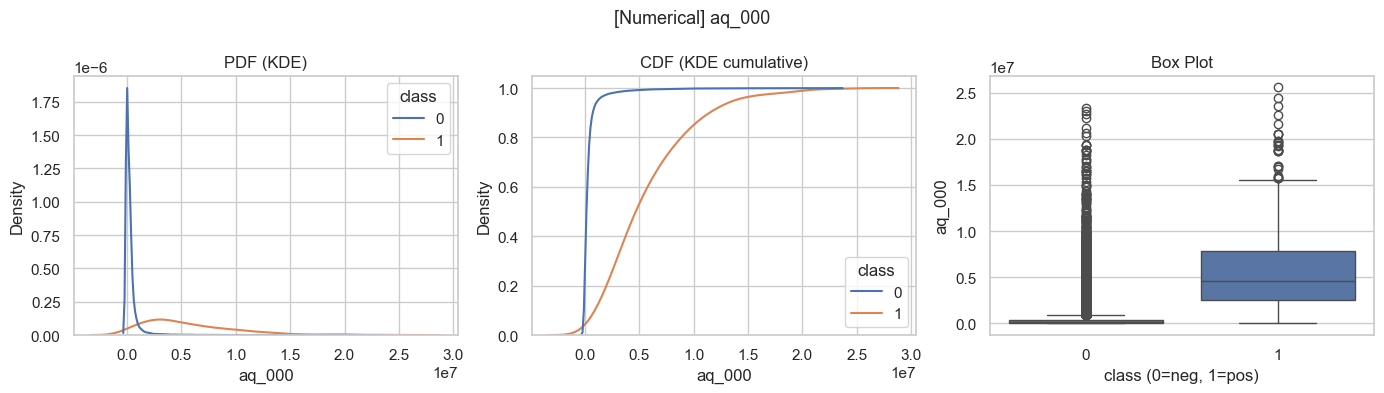

****************************************************************************************************
Feature 'az_001', Class 1 → Mean: 69608.5874, Std: 109024.3504
Feature 'az_001', Class 0 → Mean: 3229.3959, Std: 28132.7143


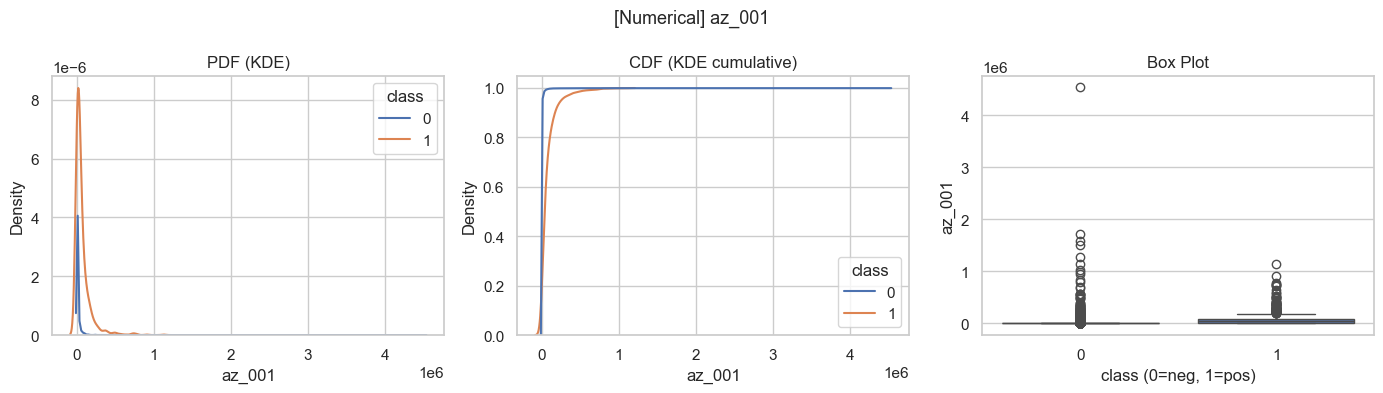

****************************************************************************************************
Feature 'bb_000', Class 1 → Mean: 50105451.4427, Std: 31202629.9151
Feature 'bb_000', Class 0 → Mean: 3772833.4577, Std: 8250967.5638


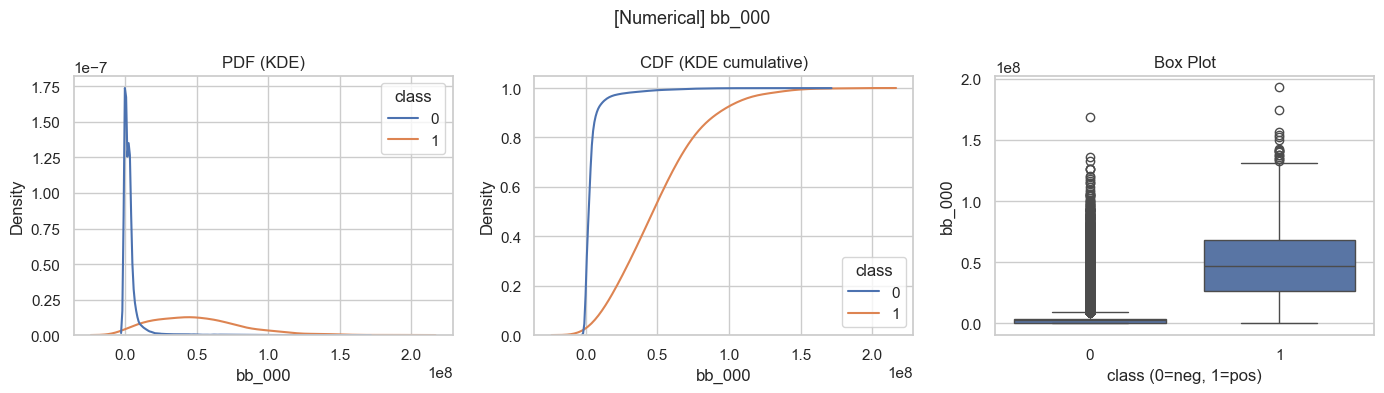

****************************************************************************************************
Feature 'bj_000', Class 1 → Mean: 7855700.5573, Std: 6806627.1868
Feature 'bj_000', Class 0 → Mean: 385575.4609, Std: 1279799.2629


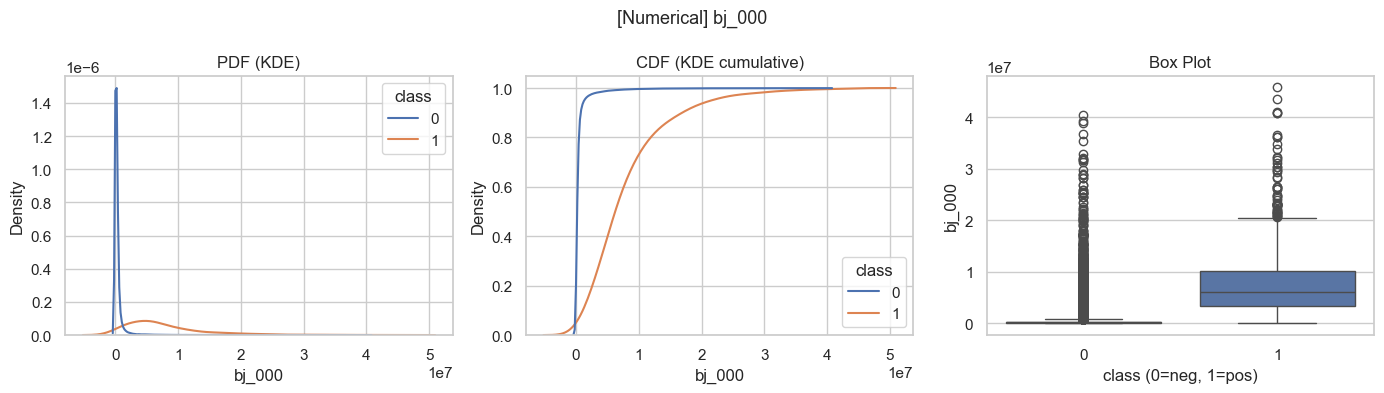

****************************************************************************************************
Feature 'bt_000', Class 1 → Mean: 661266.1703, Std: 436652.6935
Feature 'bt_000', Class 0 → Mean: 49276.3371, Std: 109958.0555


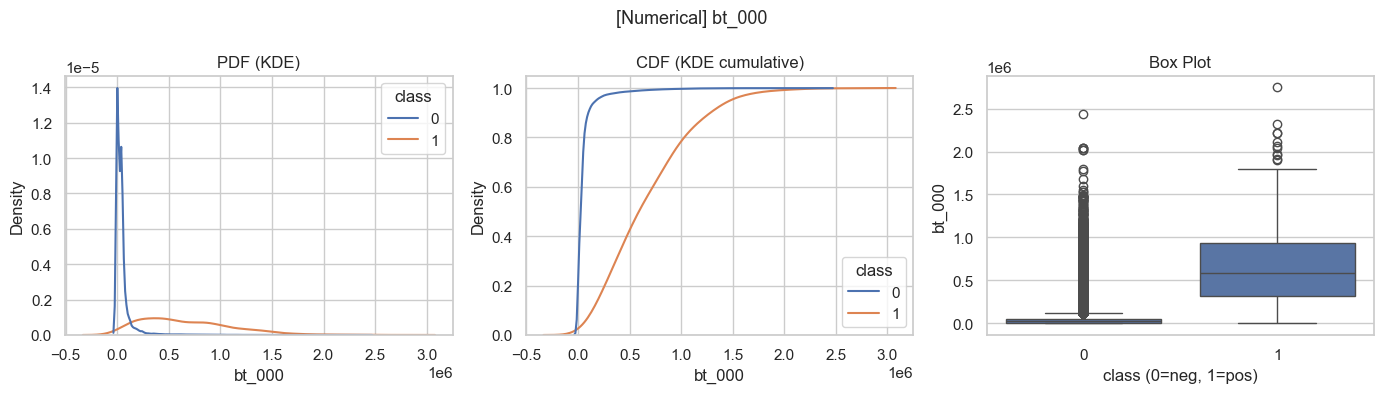

****************************************************************************************************
Feature 'bu_000', Class 1 → Mean: 50105444.9689, Std: 31202628.3097
Feature 'bu_000', Class 0 → Mean: 3772832.8924, Std: 8250967.1587


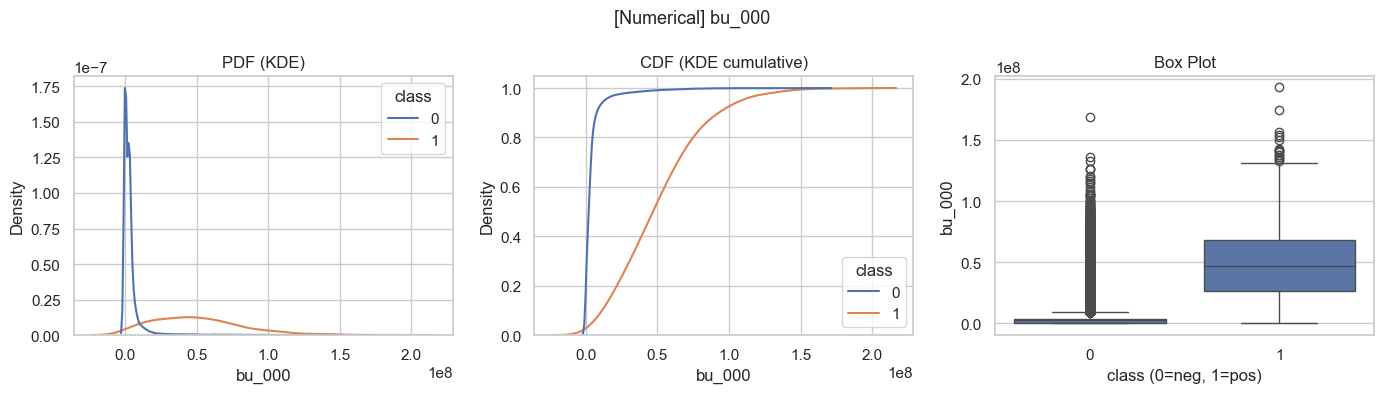

****************************************************************************************************
Feature 'by_000', Class 1 → Mean: 229945.6742, Std: 196878.4961
Feature 'by_000', Class 0 → Mean: 18553.8731, Std: 39587.1256


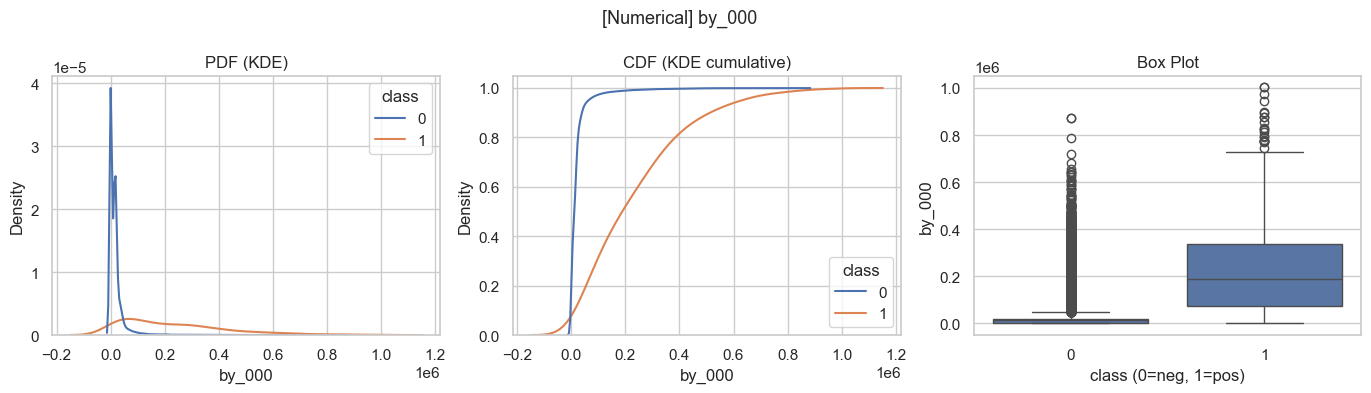

****************************************************************************************************
Feature 'ci_000', Class 1 → Mean: 39027126.8647, Std: 23780114.7959
Feature 'ci_000', Class 0 → Mean: 2886487.5057, Std: 6303933.1278


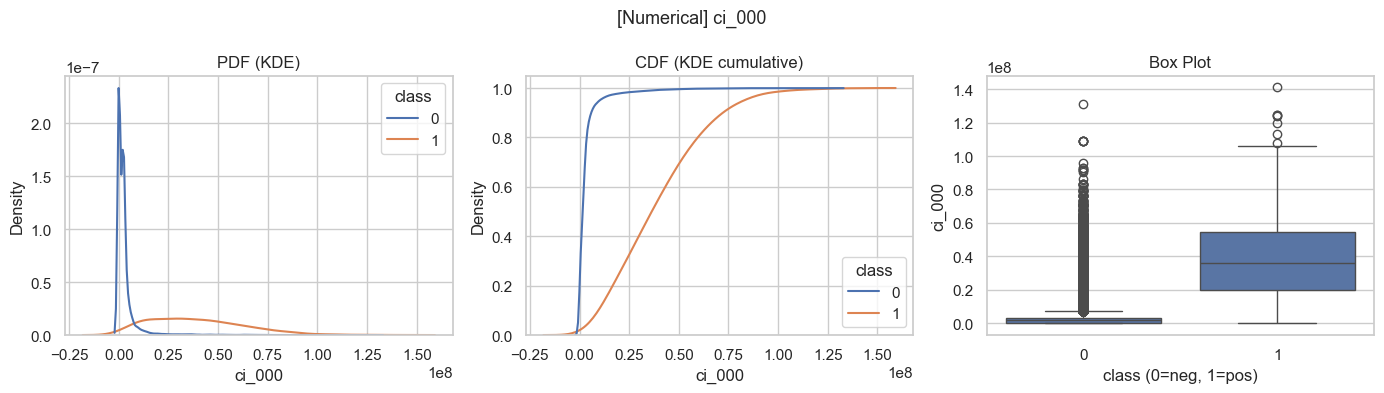

****************************************************************************************************
Feature 'ck_000', Class 1 → Mean: 8453358.6672, Std: 6507051.5205
Feature 'ck_000', Class 0 → Mean: 581101.2474, Std: 1733745.9151


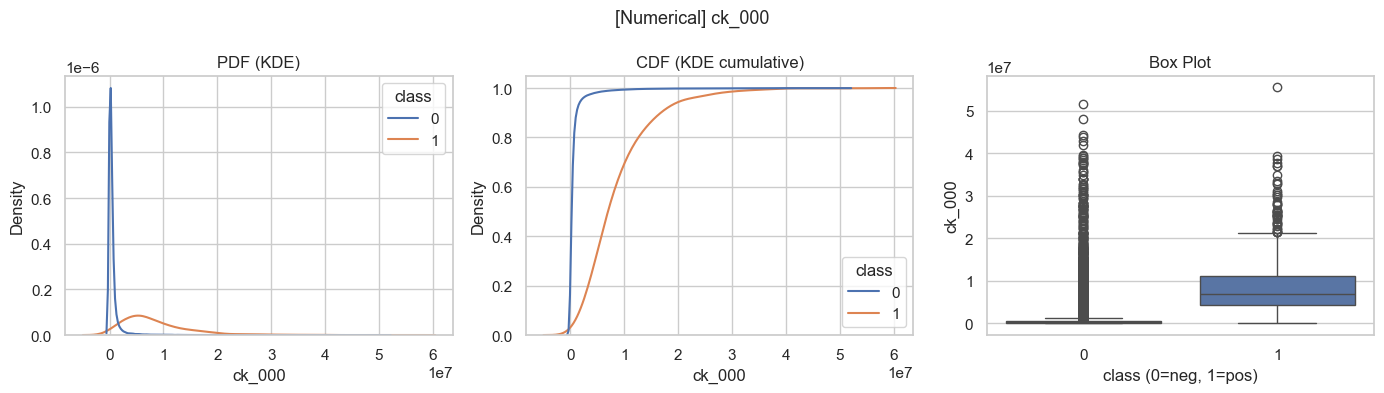

****************************************************************************************************
Feature 'cq_000', Class 1 → Mean: 50105445.0847, Std: 31202628.3366
Feature 'cq_000', Class 0 → Mean: 3772833.3829, Std: 8250967.5318


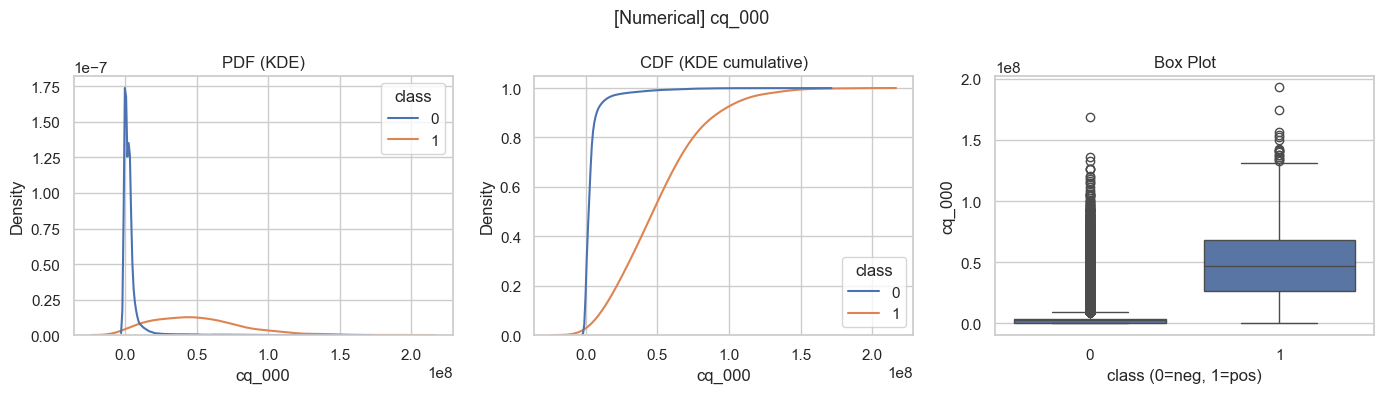

****************************************************************************************************
Feature 'dn_000', Class 1 → Mean: 405900.9282, Std: 287832.5597
Feature 'dn_000', Class 0 → Mean: 27698.4897, Std: 76969.2732


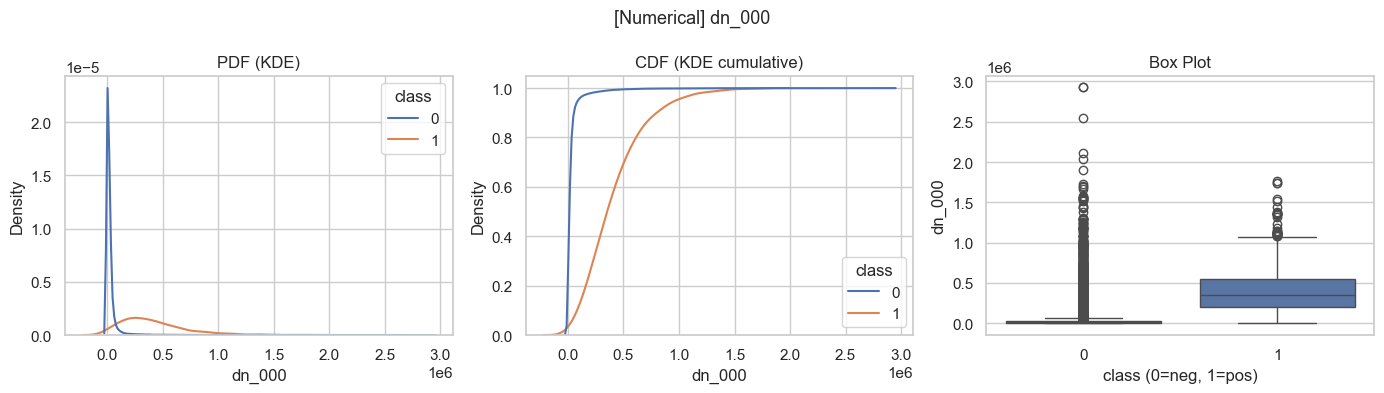

****************************************************************************************************


In [16]:
eda_plots_with_stats(X_eda_num, title_prefix="[Numerical] ")

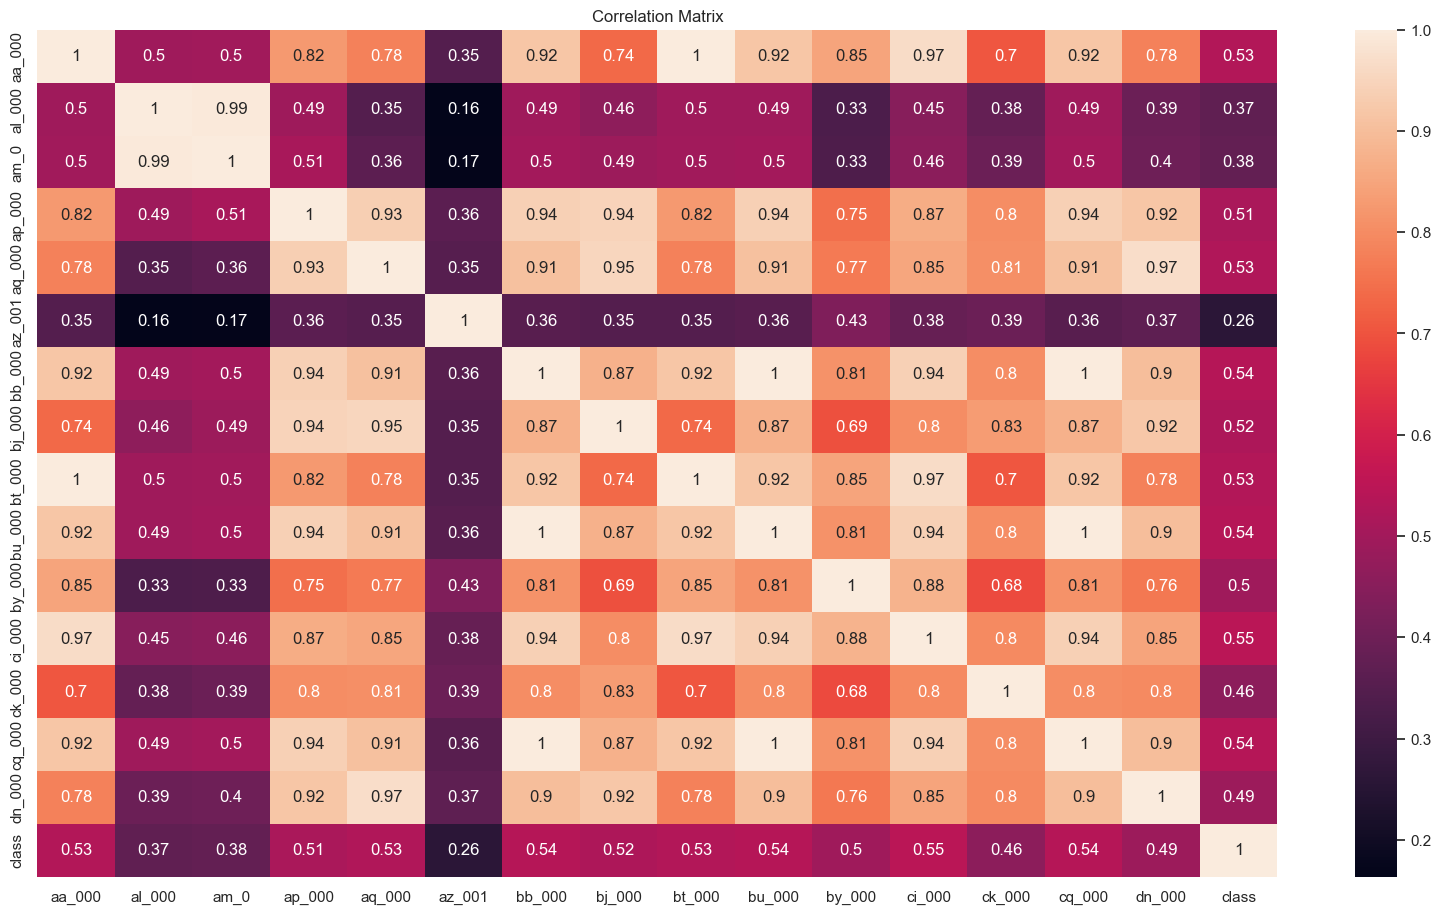

In [18]:
plt.figure(figsize=(20,11))
sns.heatmap(X_eda_num.corr(),annot=True)
plt.title("Correlation Matrix")
plt.show()

Explained variance ratio: 0.990


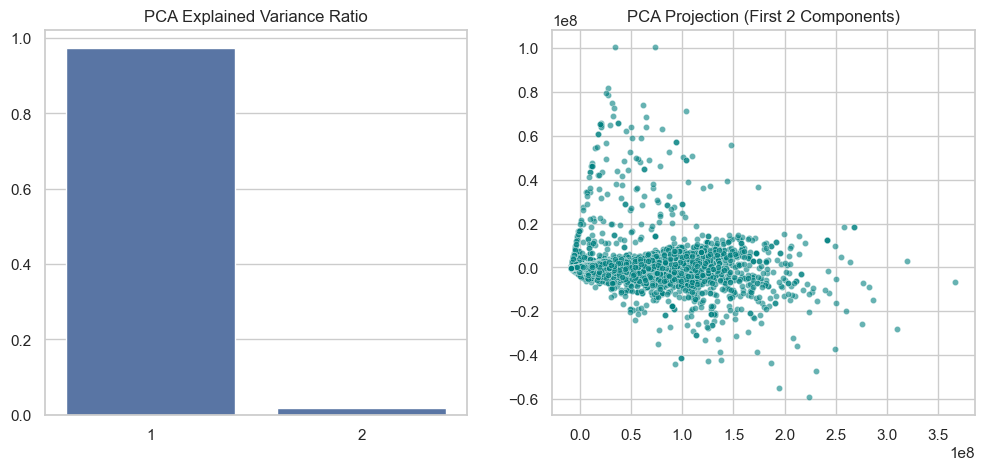

,PC1,PC2
0,4.285010e+06,120261.302950
1,-1.821678e+06,-526368.720021
2,-3.506368e+06,220695.630711
3,-8.626582e+06,-190650.807666
4,-3.403622e+05,214104.881620
...,...,...
58185,1.198759e+07,330487.885579
58186,-8.379372e+06,-161294.578376
58187,-8.588787e+06,-199866.647391
58188,3.271719e+06,38227.043463


In [19]:
pca_inspect(X_eda_num, n_components=2)     


In [16]:
# Build the selected training/test matrices with consistent columns
sel_cols = list(X_top_hist.columns) + list(X_top_num.columns)
X_train_sel = X_train_imp[sel_cols].copy()
X_test_sel  = X_test_imp[sel_cols].copy()

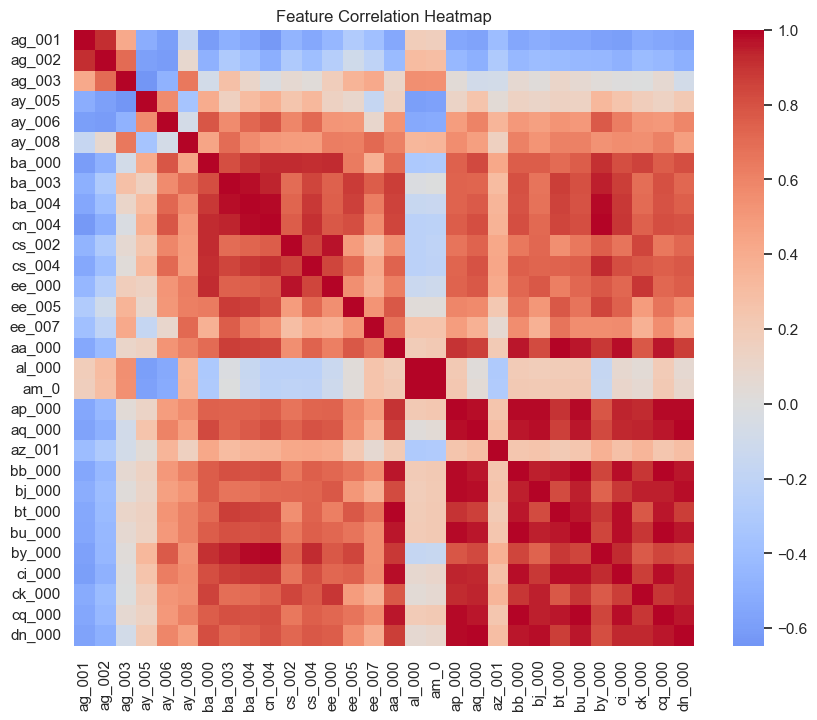

,Feature1,Feature2,Correlation
0,ag_001,ag_002,0.912538
1,ag_002,ag_001,0.912538
2,ba_000,ba_003,0.815458
3,ba_000,ba_004,0.880630
4,ba_000,cn_004,0.925844
...,...,...,...
221,dn_000,bu_000,0.961930
222,dn_000,by_000,0.819507
223,dn_000,ci_000,0.935092
224,dn_000,ck_000,0.933281


In [17]:
# PCA inspection & correlation heatmap (selected features only) ---
plot_correlation_heatmap(X_train_sel.corr())    

### Scaling & Balancing

In [ ]:
# Scale & balance (SMOTE + undersampling inside your utility) ---
# This returns scaled & balanced X/y (train only). Test remains unbalanced and will be scaled inside this function
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

RANDOM_STATE = 42  # keep global constant


# ===============================
# 🔧 SCALE + RESAMPLE (modular)
# ===============================
def scale_and_balance_2(X, y, method, sampling_strategy="auto", k_neighbors=5, use_scaler=True):
    """
    Scales and balances the dataset using the chosen resampling method.
    
    Parameters
    ----------
    X : pd.DataFrame
        Training features
    y : pd.Series or np.ndarray
        Labels
    method : str
        One of ['none', 'smote', 'smote-enn', 'smote-tomek']
    sampling_strategy : str or float
        Ratio of minority to majority after resampling
    k_neighbors : int
        Number of neighbors used by SMOTE
    use_scaler : bool
        Whether to apply MinMaxScaler before resampling
    
    Returns
    -------
    X_res : np.ndarray
        Resampled feature matrix
    y_res : np.ndarray
        Resampled target array
    scaler : MinMaxScaler
        Fitted scaler to apply on test data
    """
    if use_scaler:
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        scaler = None
        X_scaled = X.values if hasattr(X, "values") else X

    # --- Choose resampler ---
    if method == "none":
        X_res, y_res = X_scaled, y
        print(f"[No resampling] Kept original distribution: neg={sum(y==0)}, pos={sum(y==1)}")

    elif method == "smote":
        sm = SMOTE(random_state=RANDOM_STATE, sampling_strategy=sampling_strategy, k_neighbors=k_neighbors)
        X_res, y_res = sm.fit_resample(X_scaled, y)
        print(f"[SMOTE] After balancing: {sum(y_res==0)} negatives, {sum(y_res==1)} positives.")

    elif method == "smote-enn":
        smote_enn = SMOTEENN(random_state=RANDOM_STATE, sampling_strategy=sampling_strategy)
        X_res, y_res = smote_enn.fit_resample(X_scaled, y)
        print(f"[SMOTE-ENN] After balancing: {sum(y_res==0)} negatives, {sum(y_res==1)} positives.")

    elif method == "smote-tomek":
        smote_tomek = SMOTETomek(random_state=RANDOM_STATE, sampling_strategy=sampling_strategy)
        X_res, y_res = smote_tomek.fit_resample(X_scaled, y)
        print(f"[SMOTE-Tomek] After balancing: {sum(y_res==0)} negatives, {sum(y_res==1)} positives.")

    else:
        raise ValueError(f"Invalid resampling method: {method}")

    return X_res, y_res, scaler


def select_feature_dtc(X, y):
    """
    Performs feature selection using RandomForest + SelectFromModel.
    Keeps features with importance above automatic threshold.
    """
    selector = SelectFromModel(estimator=RandomForestClassifier(random_state=RANDOM_STATE)).fit(X, y)
    print(f"selector.threshold_ = {selector.threshold_}")

    selected_features = X.columns[selector.get_support()]
    print(f"Number of selected features = {selected_features.shape[0]}")

    df_support = pd.DataFrame({
        "columns": X.columns.tolist(),
        "support": selector.get_support()
    })
    df_support = df_support[df_support.support == True].reset_index(drop=True)
    print(f"Shape of selected features DataFrame: {df_support.shape}")

    return df_support, selected_features


# Try different balancing strategies
X_train_bal, y_train_bal, scaler = scale_and_balance_2(X_train_sel, y_train, method="smote-enn")
X_test_scaled = scaler.transform(X_test_sel)

[SMOTE-ENN] After balancing: 55723 negatives, 57185 positives.


### Modeling

In [28]:
# Models to try
models = {
    "LogReg": LogisticRegression(max_iter=2000, n_jobs=-1 if hasattr(LogisticRegression(), "n_jobs") else None),
    "DT":     DecisionTreeClassifier(random_state=42),
    "RF":     RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42, n_jobs=-1),
    #"GBDT":   GradientBoostingClassifier(random_state=42),
    #"ADA":    AdaBoostClassifier(n_estimators=300, random_state=42),
}

if HAS_LGBM:
    models["LGBM"] = LGBMClassifier(
        n_estimators=500, learning_rate=0.05, subsample=0.9, colsample_bytree=0.8,
        max_depth=-1, random_state=42, n_jobs=-1
    )

In [29]:
from challenge.modelling.train_eval import fmt_secs


================  MODEL TRAINING & EVALUATION  ================


Models:   0%|          | 0/4 [00:00<?, ?it/s]

CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

🧪 LogReg → Test AUC=0.988, F1=0.507, Cost=40190 | total=6.88s


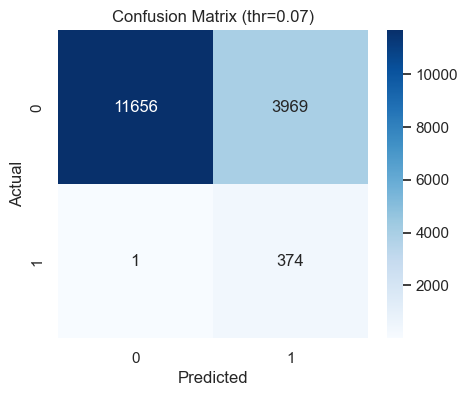

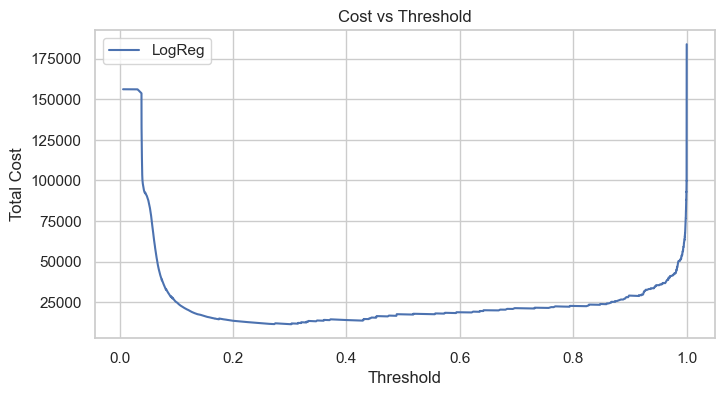

CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

🧪 DT → Test AUC=0.893, F1=0.821, Cost=39480 | total=21.33s


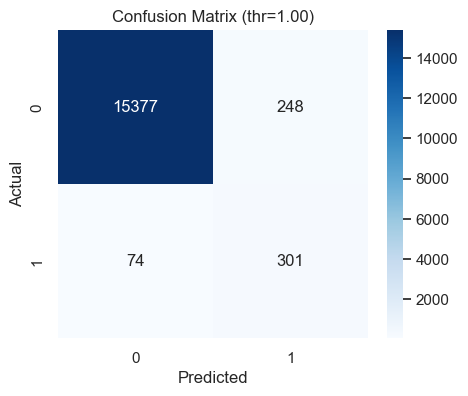

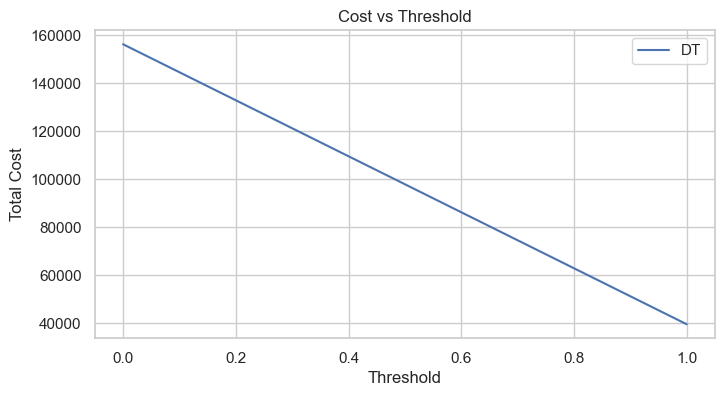

CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

🧪 RF → Test AUC=0.991, F1=0.812, Cost=13850 | total=2m 36.7s


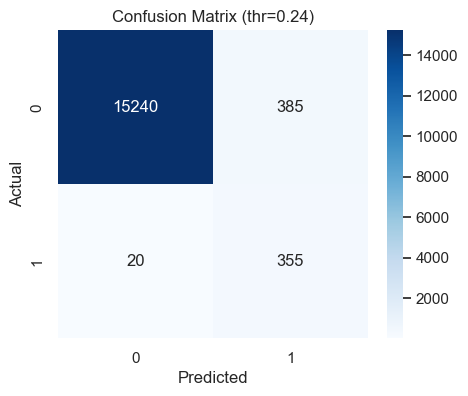

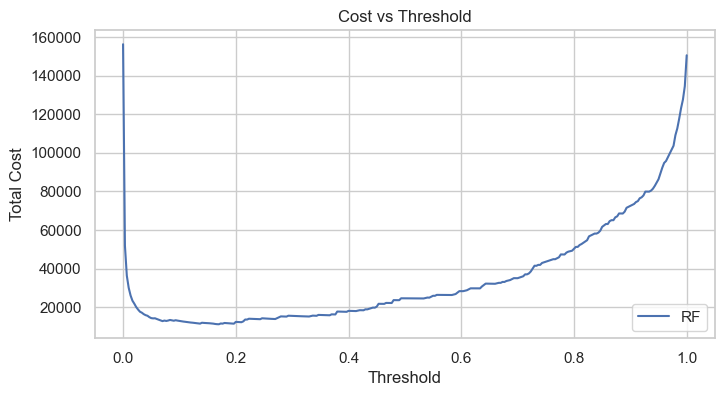

CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 45748, number of negative: 44578
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 90326, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506477 -> initscore=0.025908
[LightGBM] [Info] Start training from score 0.025908
[LightGBM] [Info] Number of positive: 45748, number of negative: 44578
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 90326, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506477 -> initscore=0.025908
[LightGBM] [Info] Start training from score 0.025908
[LightGBM] [Info

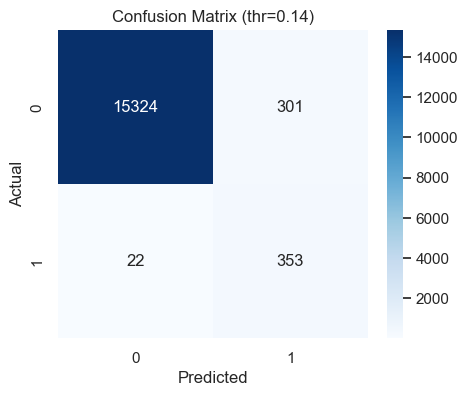

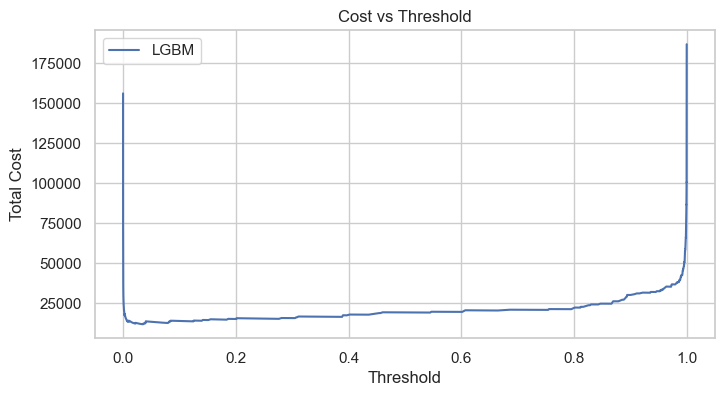


================  SUMMARY (sorted by lowest Test Cost, highest F1)  ================
 model  cv_auc  cv_f1   cv_cost  cv_fit_time  cv_pred_time  test_auc  test_f1  test_cost  test_recall  test_precision  test_fit_time  test_pred_time  threshold  total_time
    RF   1.000  0.992  1998.000       24.423         0.112     0.991    0.812  13850.000        0.947           0.480         33.695           0.110      0.237     156.652
  LGBM   1.000  0.996  1466.000        3.829         0.213     0.991    0.838  14010.000        0.941           0.540          3.896           0.112      0.136      24.360
    DT   0.993  0.993 29346.000        3.347         0.002     0.893    0.821  39480.000        0.803           0.548          4.496           0.002      1.000      21.326
LogReg   0.986  0.874 90420.000        1.207         0.001     0.988    0.507  40190.000        0.997           0.086          0.709           0.001      0.073       6.883


In [ ]:
import pandas as pd
import time
from contextlib import contextmanager
from typing import Dict, Any, Optional, Iterable
from tqdm.auto import tqdm

print("\n================  MODEL TRAINING & EVALUATION  ================")
model_iter = tqdm(models.items(), desc="Models", total=len(models))

results = []
COST_FP = 10
COST_FN = 500

for name, clf in model_iter:
    t_model = time.perf_counter()

    # CV (with progress bar per fold)
    cv_res = cv_cost(
        clf, X_train_bal, y_train_bal,
        cost_fp=COST_FP, cost_fn=COST_FN,
        folds=5, sampler=None, verbose=False,
        return_threshold=True, show_progress=True
    )
    thr = cv_res["recommended_threshold"]
    model_iter.set_postfix({
        "CV AUC": f"{cv_res['AUC_mean']:.3f}",
        "CV F1": f"{cv_res['F1_mean']:.3f}",
        "CV Cost": f"{cv_res['Cost_mean']:.0f}",
        "thr": f"{thr:.3f}"
    })

    # Test
    test_res = evaluate_on_test(
        clf, X_train_bal, y_train_bal,
        X_test_scaled, y_test,
        threshold=thr,
        cost_fp=COST_FP, cost_fn=COST_FN,
        sampler=None, verbose=False
    )

    elapsed_model = time.perf_counter() - t_model
    print(f"🧪 {name} → Test AUC={test_res['AUC']:.3f}, F1={test_res['MacroF1']:.3f}, "
          f"Cost={test_res['Cost']:.0f} | total={fmt_secs(elapsed_model)}")

    # Visuals (optional during sweeps)
    y_prob_test = clf.predict_proba(X_test_scaled)[:, 1]
    plot_confusion(y_test, y_prob_test, threshold=thr, normalize=False)
    plot_cost_threshold_curve(y_test, y_prob_test, cost_fp=COST_FP, cost_fn=COST_FN, label=name)

    results.append({
        "model": name,
        "cv_auc": cv_res["AUC_mean"],
        "cv_f1": cv_res["F1_mean"],
        "cv_cost": cv_res["Cost_mean"],
        "cv_fit_time": cv_res["fit_time_mean"],
        "cv_pred_time": cv_res["pred_time_mean"],
        "test_auc": test_res["AUC"],
        "test_macro_f1": test_res["MacroF1"],
        "test_cost": test_res["Cost"],
        "test_recall": test_res["Recall_pos"],
        "test_precision": test_res["Precision_pos"],
        "test_fit_time": test_res["fit_time"],
        "test_pred_time": test_res["pred_time"],
        "threshold": thr,
        "total_time": elapsed_model,
    })

# Summary table
summary_df = pd.DataFrame(results).sort_values(
    by=["test_cost", "test_macro_f1"], ascending=[True, False]
)
print("\n================  SUMMARY (sorted by lowest Test Cost, highest F1)  ================")
print(summary_df.to_string(index=False, float_format=lambda x: f"{x:.3f}"))
